<a href="https://colab.research.google.com/github/uazech/data-mining-velo/blob/master/script/projet_velo_sujet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet

Le projet consiste à prévoir le nombre de vélos loués à chaque heure dans des bornes libres-services de la ville (système type Vélib'). La variable cible est ici la variable **count**.

Voici un descriptif de l'ensemble des variables :
* *datetime* - date et heure du relevé 
* *season* - 1 = printemps , 2 = été, 3 = automne, 4 = hiver 
* *holiday* – indique si le jour est un jour de vacances scolaires 
* *workingday* - indique si le jour est travaillé (ni week-end ni vacances) 
* *weather* - 1: Dégagé à nuageux, 2 : Brouillard, 3 : Légère pluie ou neige, 4 : Fortes averses ou neiges 
* *temp* – température en degrés Celsius 
* *atemp* – température ressentie en degrés Celsius 
* *humidity* – taux d’humidité 
* *windspeed* – vitesse du vent 
* *casual* - nombre de locations d’usagers non abonnés 
* *registered* – nombre de locations d’usagers abonnés 
* *count* – nombre total de locations de vélos 

L'objectif du projet est de mener à bien la création d'un modèle qui pourrait théoriquement être déployé en production. Les étapes d'exploration des données, de traitement et de preprocessing ne sont bien entendu pas à négliger. Il ne s'agit pas d'une compétition de type *Kaggle*, le projet ne sera pas uniquement noté sur la performance du modèle, mais plutôt sur votre approche complète et la justification de chacun de vos choix.

Comme vu durant le cours, soyez faites attention à certains points :
- quel type de problème dois-je traiter ?
- feature engineering : est-ce que j'utilise les données correctement, toutes les données ?
- data leakage : est-ce qu'une de mes features n'est pas trop explicative ?
- ai-je bien traité toutes les données correctement ?
- est-ce que mon modèle est adapté ?
- etc, etc, etc

Soyez vigilant à expliquer et justifier votre démarche à l'aide de visualisation, de commentaires dans vos codes (pensez aux cellules markdown), etc

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Lecture et préparation des données

##Lecture des données

Chargement du fichier velo.csv et affichage des données

*   Élément de liste
*   Élément de liste



In [108]:
url = "https://raw.githubusercontent.com/uazech/data-mining-velo/master/data/input/velo.csv"
df = pd.read_csv(url)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Affichage du nombre unique de données par colonne. Permet de vérifier qu'il n'y a pas d'anomalies dans les données. 

In [109]:
df.nunique()

datetime      10886
season            4
holiday           2
workingday        2
weather           4
temp             49
atemp            60
humidity         89
windspeed        28
casual          309
registered      731
count           822
dtype: int64

Affichage du nombre de valeur manquante par colonne, afin de vérifier si on doit les traiter ou non.

Il n'y a pas de valeur manquante.

In [110]:
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

Affichage des types de chaque feature. On remarque que : 
* La variable ```season``` est une variable catégorielle, et ne devrait pas être de type entier
* La variable ```datetime``` est considérée comme une variable catégorielle, à convertir en timeserie
* La variable ```weather``` est considérée comme une variable entière, alors qu'elle devrait être de type catégorielle
* 

In [111]:
df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

Deux variables semblent suspectes. En effet, dans l'affichage du head précédent, la target était égale à la somme des deux variable registered et casual.

Dans la description des données, ces deux variables semblent également liées.

In [112]:
df["tmp"] = df["registered"] + df["casual"]
(df[df["count"] == df["tmp"]].count()) == (df.count())

datetime      True
season        True
holiday       True
workingday    True
weather       True
temp          True
atemp         True
humidity      True
windspeed     True
casual        True
registered    True
count         True
tmp           True
dtype: bool

Les données sont effectivement liées. Les colonnes casual et registered seront à supprimer lors de la préparation des données. 
En effet, on ne connait pas le nombre de locations de vélo de type casual et registred lorsque l'on cherche à prédire le nombre de locations pour une journée.

## Préparation des données

Catégorisation des colonnes et changement des valeurs associées aux libellés

In [0]:
# Changement du type en série temporelle
df['datetime'] = pd.to_datetime(df['datetime'])  

# changement des types en catégoriels
df["season"] = df.season.map({1:"printemps", 2:"ete", 3:"automne", 4:"hiver"})
df["weather"] = df.weather.map({1:"degage_nuageux", 2:"brouillard", 3:"legere_pluie_neige", 4:"forte_averses_neige"})
df["season"] = pd.Categorical(df["season"], ordered=False)
df["weather"] = pd.Categorical(df["weather"], ordered=False)
df["holiday"] = pd.Categorical(df["holiday"], ordered=False)
df["workingday"] = pd.Categorical(df["workingday"], ordered=False)


Suppression des colonnes

In [0]:
df = df.drop("casual", axis=1)
df = df.drop("registered", axis=1)
df = df.drop("tmp", axis=1) 

Définition de l'index du dataframe.

On choisit ici la colonne datetime, car les valeurs sont caractéristiques des données et qu'il n'y a pas de doublons.

In [115]:
df.set_index("datetime")

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
datetime,,,,,,,,,
2011-01-01 00:00:00,printemps,0,0,degage_nuageux,9.84,14.395,81,0.0000,16
2011-01-01 01:00:00,printemps,0,0,degage_nuageux,9.02,13.635,80,0.0000,40
2011-01-01 02:00:00,printemps,0,0,degage_nuageux,9.02,13.635,80,0.0000,32
2011-01-01 03:00:00,printemps,0,0,degage_nuageux,9.84,14.395,75,0.0000,13
2011-01-01 04:00:00,printemps,0,0,degage_nuageux,9.84,14.395,75,0.0000,1
...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,hiver,0,1,degage_nuageux,15.58,19.695,50,26.0027,336
2012-12-19 20:00:00,hiver,0,1,degage_nuageux,14.76,17.425,57,15.0013,241
2012-12-19 21:00:00,hiver,0,1,degage_nuageux,13.94,15.910,61,15.0013,168


Affichage des types et du dataframe

In [116]:
df.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
count                  int64
dtype: object

In [117]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,printemps,0,0,degage_nuageux,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,printemps,0,0,degage_nuageux,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,printemps,0,0,degage_nuageux,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,printemps,0,0,degage_nuageux,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,printemps,0,0,degage_nuageux,9.84,14.395,75,0.0,1


# Exploration des données

## Analyse numérique

Il y a 10886 données. On peut pour chaque donnée numérique regarder la moyenne, l'écart type et les quartiles.

In [118]:
df.describe()

,temp,atemp,humidity,windspeed,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,191.574132
std,7.79159,8.474601,19.245033,8.164537,181.144454
min,0.82000,0.760000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,42.000000
50%,20.50000,24.240000,62.000000,12.998000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,284.000000
max,41.00000,45.455000,100.000000,56.996900,977.000000


In [119]:
df.nunique()

datetime      10886
season            4
holiday           2
workingday        2
weather           4
temp             49
atemp            60
humidity         89
windspeed        28
count           822
dtype: int64

## Analyse univariée

### Variables numériques

Analyse de la répartition du nombre de location

In [120]:
df.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
count                  int64
dtype: object

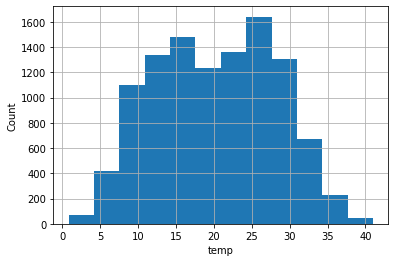

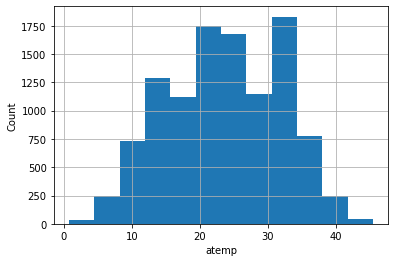

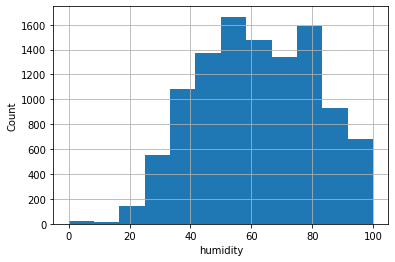

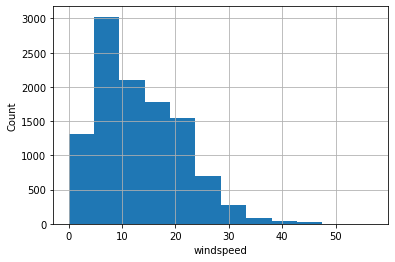

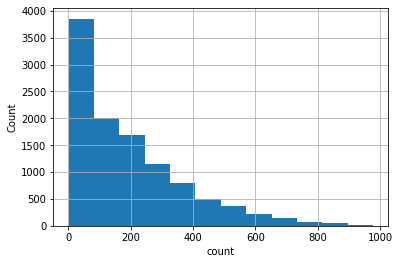

In [121]:
for colname, serie in df.iteritems():
  if serie.dtype.name in ['float64', 'int64']:
      serie.hist(bins=12)
      plt.title=" hist"
      plt.xlabel(colname)
      plt.ylabel("Count")
      plt.show()

On remarque que les variables météorologiques semblent suivrent une distribution gaussienne.

La variable count semble suivre une loie exponentielle 

### Variables catégorielles

In [122]:
for colname, serie in df.iteritems():
    # print(colname, serie.dtype.name)
    if serie.dtype.name in ['category']:
      print(df.groupby(colname)["datetime"].count(), "\n")

season
automne      2733
ete          2733
hiver        2734
printemps    2686
Name: datetime, dtype: int64 

holiday
0    10575
1      311
Name: datetime, dtype: int64 

workingday
0    3474
1    7412
Name: datetime, dtype: int64 

weather
brouillard             2834
degage_nuageux         7192
forte_averses_neige       1
legere_pluie_neige      859
Name: datetime, dtype: int64 



On remarque que les données sont relativement bien réparties.

Cependant, nous n'avons qu'une donnée pour la feature "weather" avec la modalité "forte_averses_neige".

Peut-être faudrait il la remplacer par une autre modalité ?

J'ai fait le choix de la remplacer par la modalité "legere_pluie_neige", pour limiter le nombre de modalité.


In [123]:
df.weather.replace({"forte_averses_neige":"legere_pluie_neige"}, inplace=True)
df.groupby("weather")["datetime"].count()

weather
brouillard            2834
degage_nuageux        7192
legere_pluie_neige     860
Name: datetime, dtype: int64

### Série temporelle & feature enginering




Les dates sont des attributs particuliers. Nous allons réaliser du feature engineering afin d'en extraire des informations intéressantes.

Il y a 10886 valeurs uniques, comprises entre le 1er janvier 2011 à minuit et le 19 décembre 2012 à 23h.

In [124]:
df.datetime.describe()


count                   10886
unique                  10886
top       2011-06-09 04:00:00
freq                        1
first     2011-01-01 00:00:00
last      2012-12-19 23:00:00
Name: datetime, dtype: object

On réalise du feature engineering pour calculer :
* l'année
* le mois
* le jour de la semaine
* le jour
* l'heure
* le timestamp


In [0]:
# On garde l'année
df['year'] = pd.DatetimeIndex(df['datetime']).year
# On garde le mois de l'enregistrement
df['month'] = pd.DatetimeIndex(df['datetime']).month
# On garde le jour de l'enregistrement
df['day'] = pd.DatetimeIndex(df['datetime']).day
# On garde l'heure de l'enregistrement
df['hour'] = pd.DatetimeIndex(df['datetime']).hour
# On garde le jour de la semaine 
df['dayofweek'] = pd.DatetimeIndex(df['datetime']).dayofweek.map({0:"lundi", 1:"mardi", 2:"mercredi", 3:"jeudi", 4:"vendredi", 5:"samedi", 6:"dimanche"})

# On garde le timestamp pour une notion de continuité d'une année sur l'autre
df["timestamp"] = df.datetime.values.astype(np.int64) // 10 ** 9 

df["dayofweek"] = pd.Categorical(df["dayofweek"], ordered=True)
df["hour"] = pd.Categorical(df["hour"], ordered=True)
df["day"] = pd.Categorical(df["day"], ordered=True)
df["month"] = pd.Categorical(df["month"], ordered=True)
df["year"] = pd.Categorical(df["year"], ordered=True)



In [126]:
df.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather               object
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
count                  int64
year                category
month               category
day                 category
hour                category
dayofweek           category
timestamp              int64
dtype: object

In [127]:
df.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,dayofweek,timestamp
10881,2012-12-19 19:00:00,hiver,0,1,degage_nuageux,15.58,19.695,50,26.0027,336,2012,12,19,19,mercredi,1355943600
10882,2012-12-19 20:00:00,hiver,0,1,degage_nuageux,14.76,17.425,57,15.0013,241,2012,12,19,20,mercredi,1355947200
10883,2012-12-19 21:00:00,hiver,0,1,degage_nuageux,13.94,15.910,61,15.0013,168,2012,12,19,21,mercredi,1355950800
10884,2012-12-19 22:00:00,hiver,0,1,degage_nuageux,13.94,17.425,61,6.0032,129,2012,12,19,22,mercredi,1355954400
10885,2012-12-19 23:00:00,hiver,0,1,degage_nuageux,13.12,16.665,66,8.9981,88,2012,12,19,23,mercredi,1355958000



## Analyse mutlivariée

### Correlations

On remarque que la température réele et la température ressentie sont fortmement corrélées.

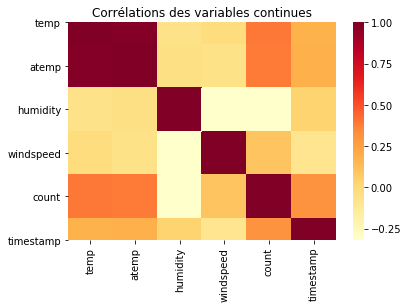

In [128]:
ax = sns.heatmap(df.corr(), cmap="YlOrRd")
ax.set_title("Corrélations des variables continues")
plt.show()

In [129]:
df.corr()

,temp,atemp,humidity,windspeed,count,timestamp
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454,0.180986
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784,0.181823
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371,0.032856
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369,-0.086888
count,0.394454,0.389784,-0.317371,0.101369,1.000000,0.310187
timestamp,0.180986,0.181823,0.032856,-0.086888,0.310187,1.000000


Une corrélation de 98.5 entre les deux variables est trop importante. On supprimera donc une des deux colonnes.

Le choix se porte sur la température ressentie.

In [0]:
df.drop("atemp",axis=1, inplace=True)

### Analyses

On remarque que le fait que le jour soit férié n'a pas une importance capitale. Cependant, les jours non férié sont les jours durant lesquels il y a le plus de location.

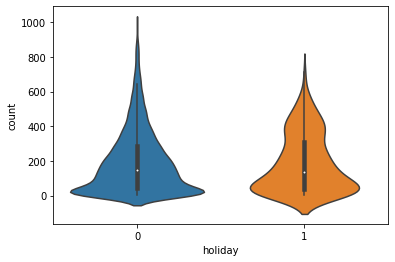

In [131]:
sns.violinplot(x="holiday", y="count", data=df)
plt.show()

Etrangement le 1er janvier n'est pas considéré comme un jour ferié et le 17 novembre est un jour ferié. Il convidendrait de vérifier plus en détail la veracité des données pour cette feature

In [136]:
df[df['holiday']==1].datetime.head()

372   2011-01-17 00:00:00
373   2011-01-17 01:00:00
374   2011-01-17 02:00:00
375   2011-01-17 03:00:00
376   2011-01-17 04:00:00
Name: datetime, dtype: datetime64[ns]

On remarque que la saison a une grande importance sur le nombre de vélos loués.

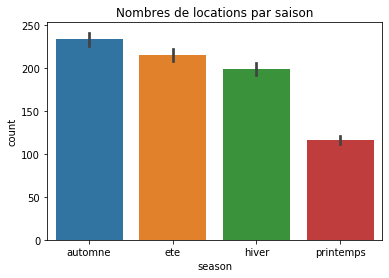

In [132]:
ax = sns.barplot(x="season", y="count", data=df)
ax.set_title("Nombres de locations par saison")
plt.show()

On remarque l'importance particulièrement élevé des mois sur les ventes.

Cette variable semble plus significative que la saison. Il conviendra peut-être de dropper la saison. // TODO

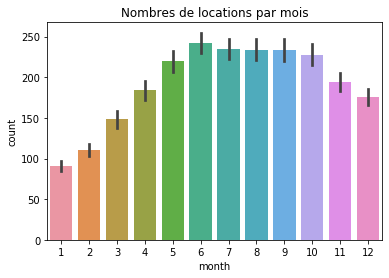

In [133]:
ax = sns.barplot(x="month", y="count", data=df)
ax.set_title("Nombres de locations par mois")
plt.show()

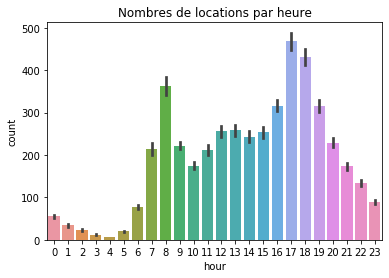

In [137]:
ax = sns.barplot(x="hour", y="count", data=df)
ax.set_title("Nombres de locations par mois")
plt.show()

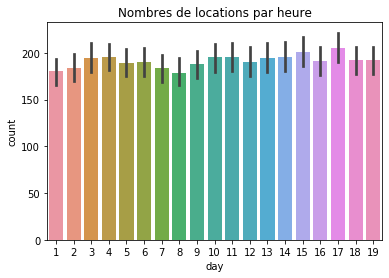

In [140]:
ax = sns.barplot(x="day", y="count", data=df)
ax.set_title("Nombres de locations par heure")
plt.show()